In [2]:
# Mounting your Google Drive is optional, and you could also simply copy and
# upload the data to your colab instance. This manula upload is also easy to do, 
# but you will have to figure out how to do it.
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
import os
if not os.path.exists("/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4"):
    os.makedirs("/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4")
os.chdir("/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4")

In [4]:
# download dataset
!wget https://drive.switch.ch/index.php/s/UG0ZlZXY47LKSaW/download
!unzip download
!rm download
%cd data
!unzip -qqo albertville_rgb.zip
!unzip -qqo albertville_normal.zip
!unzip -qqo albertville_principal_curvature.zip
!unzip -qqo almena_rgb.zip
!unzip -qqo almena_normal.zip
!unzip -qqo almena_principal_curvature.zip
!rm albertville_rgb.zip albertville_normal.zip albertville_principal_curvature.zip almena_rgb.zip almena_normal.zip almena_principal_curvature.zip
%cd ..
!ls

--2021-05-03 23:52:10--  https://drive.switch.ch/index.php/s/UG0ZlZXY47LKSaW/download
Resolving drive.switch.ch (drive.switch.ch)... 86.119.34.137, 86.119.34.138, 2001:620:5ca1:1ee::12, ...
Connecting to drive.switch.ch (drive.switch.ch)|86.119.34.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download’

download                [  <=>               ] 387.57M  29.9MB/s    in 14s     

2021-05-03 23:52:25 (27.4 MB/s) - ‘download’ saved [406396331]

Archive:  download
 extracting: data/albertville_normal.zip  
 extracting: data/albertville_principal_curvature.zip  
 extracting: data/albertville_rgb.zip  
 extracting: data/almena_normal.zip  
 extracting: data/almena_principal_curvature.zip  
 extracting: data/almena_rgb.zip     
/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4/data
/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4
data		 Q1_label_predictions.npy  vis_valset.pdf
mp4_q1_plot.png  Q2_normal_predict

In [5]:
import glob
import os
import numpy as np
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import models
from torchvision.transforms import ToTensor, Normalize
import torch.optim as optim

In [6]:
# global variable
device = torch.device("cuda:0")

In [7]:
class NormalDataset(data.Dataset):
    """
    Data loader for the Suface Normal Dataset. If data loading is a bottleneck, 
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as 
    to limit delays due to disk reads.
    """
    def __init__(self, split="train", data_dir="./data"):
        assert(split in ["train", "val"])
        split2name = {
            "train": "almena",
            "val": "albertville",
        }
        self.img_dir = os.path.join(data_dir, split2name[split] + "_rgb", "rgb")
        self.gt_dir = os.path.join(data_dir, split2name[split] + "_normal", "normal")
        
        self.split = split
        self.filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*.png")
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + ".png")
        img = np.asarray(img).copy()
        gt = Image.open(os.path.join(self.gt_dir, filename.replace("_rgb", "_normal")) + ".png")
        gt = np.asarray(gt)

        # from rgb image to surface normal
        gt = gt.astype(np.float32) / 255
        gt = torch.Tensor(np.asarray(gt).copy()).permute((2, 0, 1))
        mask = self.build_mask(gt).to(torch.float)

        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

        # normalize gt
        gt = gt * 2 - 1
        
        return img.contiguous(), gt, mask.sum(dim=0) > 0

    @staticmethod
    def build_mask(target, val=0.502, tol=1e-3):
        target = target.unsqueeze(0)
        if target.shape[1] == 1:
            mask = ((target >= val - tol) & (target <= val + tol))
            mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
            return (~mask).expand_as(target).squeeze(0)

        mask1 = (target[:, 0, :, :] >= val - tol) & (target[:, 0, :, :] <= val + tol)
        mask2 = (target[:, 1, :, :] >= val - tol) & (target[:, 1, :, :] <= val + tol)
        mask3 = (target[:, 2, :, :] >= val - tol) & (target[:, 2, :, :] <= val + tol)
        mask = (mask1 & mask2 & mask3).unsqueeze(1)
        mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
        return (~mask).expand_as(target).squeeze(0)

In [8]:
class ASPP(nn.Module):
    def __init__(self, in_channels = 512, out_channels = 256):
        super(ASPP, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)
        self.pool = nn.AdaptiveAvgPool2d(1)  

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=6, dilation=6, bias=False)
        self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=12, dilation=12, bias=False)
        self.conv4 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=18, dilation=18, bias=False)
        self.conv5 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False)

        self.conv = nn.Conv2d(in_channels=out_channels * 5, out_channels=out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn(x1)
        x1 = self.relu(x1)

        x2 = self.conv2(x)
        x2 = self.bn(x2)
        x2 = self.relu(x2)

        x3 = self.conv3(x)
        x3 = self.bn(x3)
        x3 = self.relu(x3)

        x4 = self.conv4(x)
        x4 = self.bn(x4)
        x4 = self.relu(x4)

        x5 = self.pool(x)
        x5 = self.conv5(x5)
        x5 = self.bn(x5)
        x5 = self.relu(x5)
        x5 = F.interpolate(x5, size=tuple(x4.shape[-2:]), mode='bilinear', align_corners=True)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [9]:
class Decoder(nn.Module):
    def __init__(self, ll_channels = 64, out_channels = 3):
        super(Decoder, self).__init__()

        self.conv_ll = nn.Conv2d(in_channels=ll_channels, out_channels=48, kernel_size=1, bias=False)
        self.bn_ll = nn.BatchNorm2d(48)
        self.relu = nn.ReLU(inplace=True)

        # https://arxiv.org/pdf/1802.02611.pdf table 2
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=256+48, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(in_channels=256, out_channels=out_channels, kernel_size=1, stride=1))
        
    def forward(self, x, low_level):
        low_level = self.conv_ll(low_level)
        low_level = self.bn_ll(low_level)
        low_level = self.relu(low_level)

        x = F.interpolate(x, size=tuple(low_level.shape[-2:]), mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level), dim = 1)
        x = self.conv(x)

        return x

In [10]:
# Grammer in this section is referenced from 
# https://github.com/mortezamg63/Accessing-and-modifying-different-layers-of-a-pretrained-model-in-pytorch
# https://towardsdatascience.com/using-predefined-and-pretrained-cnns-in-pytorch-e3447cbe9e3c
# Structure reference from
# https://arxiv.org/pdf/1802.02611.pdf : Deeplab V3+

class MyModel(nn.Module):
    def __init__(self): # feel free to modify input paramters
        super(MyModel, self).__init__()
        
        # Encoder
        resnet18 = models.resnet18(pretrained=True)
        self.resnet18_head = nn.Sequential(*(list(resnet18.children())[0:4]))
        self.resnet18_layer1 = nn.Sequential(*(list(resnet18.children())[4]))
        self.resnet18_layer2 = nn.Sequential(*(list(resnet18.children())[5]))
        self.resnet18_layer3 = nn.Sequential(*(list(resnet18.children())[6]))
        self.resnet18_layer4 = nn.Sequential(*(list(resnet18.children())[7]))

        # Atrous Spatial Pyramid Pooling
        self.aspp = ASPP(in_channels = 512, out_channels = 256)
        
        # Decoder
        self.decoder = Decoder(ll_channels = 64, out_channels = 3)

        # self.conv2 = nn.Conv2d(in_channels = 256, out_channels = 3, kernel_size = 1)

    def forward(self, x): # feel free to modify input paramters
        # Get input size for later use
        _, _, h, w = x.shape        # 3 * 512 * 512

        # Construct Resnet18 and save low level feature
        x = self.resnet18_head(x)   # 64 * 128 * 128
        x = self.resnet18_layer1(x) # 64 * 128 * 128
        low_level = x
        x = self.resnet18_layer2(x) # 128 * 64 * 64
        x = self.resnet18_layer3(x) # 256 * 32 * 32
        x = self.resnet18_layer4(x) # 512 * 16 * 16

        # Construct Atrous Spatial Pyramid Pooling
        x = self.aspp(x)            # 256 * 16 * 16

        # Construct Decoder
        x = self.decoder(x, low_level)  # 3 * 128 * 128

        # x = self.conv2(x)

        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)
        x = F.normalize(x)

        return x

In [11]:
##########
#TODO: define your loss function here
##########
class MyCriterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()
        pass

    def forward(self, prediction, target, mask):
        pass


In [12]:
def simple_train(model, criterion, optimizer, train_dataloader, epoch, **kwargs):
    # Set the model to trainning mode
    model.train()
    
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs
        inputs, labels, bool_mask = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print(loss.shape)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # Normalizing the loss by the total number of train batches
    running_loss/=len(train_dataloader)
    print(len(train_dataloader))
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))


In [13]:
def angle_error(prediction, target):
    prediction_error = torch.cosine_similarity(prediction, target)
    prediction_error = torch.clamp(prediction_error, min=-1.0, max=1.0)
    prediction_error = torch.acos(prediction_error) * 180.0 / np.pi
    return prediction_error

def simple_predict(split, model):
    model.eval()
    dataset = NormalDataset(split=split)
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    gts, preds, losses = [], [], []
    total_normal_errors = None
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, gt, mask = batch
            img = img.to(device)
            gt = gt.to(device)
            mask = mask.to(device)

            pred = model(img)
            loss = (F.l1_loss(pred, gt, reduction="none") * mask).mean()

            gts.append((gt[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            losses.append(loss.item())

            angle_error_prediction = angle_error(pred, gt)
            angle_error_prediction = angle_error_prediction[mask > 0].view(-1)
            if total_normal_errors is None:
                total_normal_errors = angle_error_prediction.cpu().numpy()
            else:
                total_normal_errors = np.concatenate(
                    (total_normal_errors, angle_error_prediction.cpu().numpy())
                )

    return gts, preds, losses, total_normal_errors

In [45]:
model = MyModel().to(device)
print(model)

MyModel(
  (resnet18_head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (resnet18_layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [46]:
# criterion = MyCriterion().to(device)
# criterion = nn.CosineEmbeddingLoss()
criterion = nn.L1Loss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
train_dataset = NormalDataset(split='train')
train_dataloader = data.DataLoader(train_dataset, batch_size=8, 
                                    shuffle=True, num_workers=2, 
                                    drop_last=True)

# Reference from https://arxiv.org/pdf/1506.01186.pdf
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, step_size_up=30, base_lr=0.001, max_lr=0.005, cycle_momentum=False)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, step_size_up=30, base_lr=0.0001, max_lr=0.0019, cycle_momentum=False)

In [47]:
########################################################################
# TODO: Implement your training cycles, make sure you evaluate on validation 
# dataset and compute evaluation metrics every so often. 
# You may also want to save models that perform well.

num_epochs = 65
lr_over_epochs = []
val_loss_over_epochs = []
mean_error_over_epochs = []

for epoch in tqdm(range(num_epochs), total=num_epochs):
    simple_train(model, criterion, optimizer, train_dataloader, epoch)
    # consider reducing learning rate
    print('lr: ', scheduler.get_last_lr())
    lr_over_epochs.append(scheduler.get_last_lr())
    if (epoch % 1 == 0):
        val_gts, val_preds, val_losses, val_total_normal_errors = simple_predict('val', model)
        print("Validation loss (L1):", np.mean(val_losses))
        print("Validation metrics: Mean %.1f, Median %.1f, 11.25deg %.1f, 22.5deg %.1f, 30deg %.1f" % (
            np.average(val_total_normal_errors), np.median(val_total_normal_errors),
            np.sum(val_total_normal_errors < 11.25) / val_total_normal_errors.shape[0] * 100,
            np.sum(val_total_normal_errors < 22.5) / val_total_normal_errors.shape[0] * 100,
            np.sum(val_total_normal_errors < 30) / val_total_normal_errors.shape[0] * 100
        ))
        if (np.average(val_total_normal_errors) <= 30.5):
            torch.save(model, './model_'+str(epoch))
        val_loss_over_epochs.append(np.mean(val_losses))
        mean_error_over_epochs.append(np.average(val_total_normal_errors))
    scheduler.step()

34
[1] loss: 0.371
lr:  [0.0001]



Validation loss (L1): 0.2846745649655151
Validation metrics: Mean 38.3, Median 32.6, 11.25deg 11.8, 22.5deg 35.2, 30deg 46.5
34
[2] loss: 0.246
lr:  [0.0001599999999999998]



Validation loss (L1): 0.2751088441055045
Validation metrics: Mean 37.2, Median 31.9, 11.25deg 14.3, 22.5deg 35.7, 30deg 47.3
34
[3] loss: 0.210
lr:  [0.00022000000000000036]



Validation loss (L1): 0.2614564777821557
Validation metrics: Mean 35.6, Median 29.2, 11.25deg 19.6, 22.5deg 40.5, 30deg 51.1
34
[4] loss: 0.193
lr:  [0.00028000000000000014]



Validation loss (L1): 0.2699158899486065
Validation metrics: Mean 37.1, Median 28.6, 11.25deg 22.3, 22.5deg 42.6, 30deg 51.6
34
[5] loss: 0.184
lr:  [0.00033999999999999997]



Validation loss (L1): 0.2471408765985925
Validation metrics: Mean 34.2, Median 25.7, 11.25deg 24.9, 22.5deg 45.5, 30deg 55.3
34
[6] loss: 0.172
lr:  [0.0003999999999999997]



Validation loss (L1): 0.23940502979561815
Validation metrics: Mean 32.8, Median 24.9, 11.25deg 25.9, 22.5deg 46.6, 30deg 56.5
34
[7] loss: 0.170
lr:  [0.0004600000000000003]



Validation loss (L1): 0.2415571799262976
Validation metrics: Mean 33.1, Median 26.0, 11.25deg 26.1, 22.5deg 45.2, 30deg 54.9
34
[8] loss: 0.168
lr:  [0.0005200000000000001]



Validation loss (L1): 0.25359735819391716
Validation metrics: Mean 34.8, Median 25.9, 11.25deg 24.3, 22.5deg 45.3, 30deg 55.1
34
[9] loss: 0.166
lr:  [0.0005799999999999999]



Validation loss (L1): 0.24927295145825443
Validation metrics: Mean 34.5, Median 24.7, 11.25deg 25.6, 22.5deg 47.1, 30deg 56.0
34
[10] loss: 0.160
lr:  [0.0006399999999999997]



Validation loss (L1): 0.2322011069736929
Validation metrics: Mean 31.7, Median 23.3, 11.25deg 27.4, 22.5deg 48.9, 30deg 58.6
34
[11] loss: 0.161
lr:  [0.0007000000000000003]



Validation loss (L1): 0.2974514964745085
Validation metrics: Mean 41.0, Median 34.4, 11.25deg 21.2, 22.5deg 37.2, 30deg 45.6
34
[12] loss: 0.165
lr:  [0.00076]



Validation loss (L1): 0.24692182281078437
Validation metrics: Mean 34.2, Median 25.4, 11.25deg 25.2, 22.5deg 46.0, 30deg 55.5
34
[13] loss: 0.162
lr:  [0.0008199999999999999]



Validation loss (L1): 0.24349661486653182
Validation metrics: Mean 33.4, Median 24.6, 11.25deg 27.9, 22.5deg 47.2, 30deg 56.3
34
[14] loss: 0.157
lr:  [0.0008800000000000005]



Validation loss (L1): 0.24788105207630712
Validation metrics: Mean 33.8, Median 25.5, 11.25deg 26.6, 22.5deg 46.0, 30deg 55.2
34
[15] loss: 0.157
lr:  [0.0009400000000000002]



Validation loss (L1): 0.25848279333012736
Validation metrics: Mean 35.5, Median 26.9, 11.25deg 27.3, 22.5deg 44.7, 30deg 53.4
34
[16] loss: 0.152
lr:  [0.001]



Validation loss (L1): 0.2451047477686507
Validation metrics: Mean 33.4, Median 26.3, 11.25deg 25.7, 22.5deg 44.8, 30deg 54.6
34
[17] loss: 0.159
lr:  [0.0010599999999999997]



Validation loss (L1): 0.2630364972875159
Validation metrics: Mean 36.5, Median 28.1, 11.25deg 28.1, 22.5deg 43.9, 30deg 51.9
34
[18] loss: 0.162
lr:  [0.0011199999999999997]



Validation loss (L1): 0.2607277090478147
Validation metrics: Mean 35.6, Median 28.5, 11.25deg 23.4, 22.5deg 42.2, 30deg 51.8
34
[19] loss: 0.163
lr:  [0.0011800000000000003]



Validation loss (L1): 0.24148560869388092
Validation metrics: Mean 33.0, Median 24.7, 11.25deg 25.4, 22.5deg 46.9, 30deg 56.6
34
[20] loss: 0.158
lr:  [0.00124]



Validation loss (L1): 0.24382810918693867
Validation metrics: Mean 33.3, Median 25.3, 11.25deg 28.1, 22.5deg 46.4, 30deg 55.6
34
[21] loss: 0.157
lr:  [0.0012999999999999997]



Validation loss (L1): 0.22603914112998888
Validation metrics: Mean 31.1, Median 21.7, 11.25deg 33.7, 22.5deg 50.9, 30deg 59.0
34
[22] loss: 0.160
lr:  [0.0013600000000000003]



Validation loss (L1): 0.2443831764225267
Validation metrics: Mean 33.3, Median 24.9, 11.25deg 26.4, 22.5deg 46.5, 30deg 56.3
34
[23] loss: 0.160
lr:  [0.00142]



Validation loss (L1): 0.23926743253683433
Validation metrics: Mean 33.0, Median 22.8, 11.25deg 32.5, 22.5deg 49.6, 30deg 57.5
34
[24] loss: 0.171
lr:  [0.00148]



Validation loss (L1): 0.27209984361488593
Validation metrics: Mean 37.9, Median 28.7, 11.25deg 27.8, 22.5deg 43.7, 30deg 51.2
34
[25] loss: 0.174
lr:  [0.0015399999999999997]



Validation loss (L1): 0.26027808806452996
Validation metrics: Mean 35.9, Median 26.4, 11.25deg 26.9, 22.5deg 45.3, 30deg 53.8
34
[26] loss: 0.170
lr:  [0.0016000000000000003]



Validation loss (L1): 0.2587733773403188
Validation metrics: Mean 35.6, Median 26.8, 11.25deg 23.7, 22.5deg 44.4, 30deg 53.6
34
[27] loss: 0.168
lr:  [0.00166]



Validation loss (L1): 0.2569895280031567
Validation metrics: Mean 35.3, Median 26.0, 11.25deg 28.3, 22.5deg 45.9, 30deg 54.1
34
[28] loss: 0.166
lr:  [0.0017199999999999997]



Validation loss (L1): 0.2522704663057613
Validation metrics: Mean 34.9, Median 25.1, 11.25deg 29.1, 22.5deg 47.1, 30deg 55.0
34
[29] loss: 0.166
lr:  [0.0017800000000000003]



Validation loss (L1): 0.2426851223039831
Validation metrics: Mean 33.6, Median 23.3, 11.25deg 30.4, 22.5deg 49.1, 30deg 57.3
34
[30] loss: 0.177
lr:  [0.0018400000000000003]



Validation loss (L1): 0.2703310952673101
Validation metrics: Mean 37.2, Median 29.2, 11.25deg 25.1, 22.5deg 42.4, 30deg 50.8
34
[31] loss: 0.184
lr:  [0.0019]



Validation loss (L1): 0.24866855899110818
Validation metrics: Mean 34.3, Median 24.8, 11.25deg 28.2, 22.5deg 47.0, 30deg 55.6
34
[32] loss: 0.171
lr:  [0.0018400000000000003]



Validation loss (L1): 0.2626539097828233
Validation metrics: Mean 36.0, Median 27.5, 11.25deg 27.3, 22.5deg 44.3, 30deg 52.6
34
[33] loss: 0.165
lr:  [0.0017800000000000003]



Validation loss (L1): 0.24157096289544025
Validation metrics: Mean 33.3, Median 22.5, 11.25deg 31.6, 22.5deg 50.0, 30deg 57.8
34
[34] loss: 0.155
lr:  [0.0017199999999999997]



Validation loss (L1): 0.2575256320464815
Validation metrics: Mean 35.5, Median 26.0, 11.25deg 28.7, 22.5deg 46.0, 30deg 54.1
34
[35] loss: 0.148
lr:  [0.00166]



Validation loss (L1): 0.23047292283457568
Validation metrics: Mean 31.6, Median 21.3, 11.25deg 31.7, 22.5deg 51.6, 30deg 60.0
34
[36] loss: 0.143
lr:  [0.0015999999999999994]



Validation loss (L1): 0.23811399853891796
Validation metrics: Mean 32.7, Median 22.3, 11.25deg 31.8, 22.5deg 50.3, 30deg 58.4
34
[37] loss: 0.141
lr:  [0.0015399999999999997]



Validation loss (L1): 0.24031259565271884
Validation metrics: Mean 32.8, Median 22.4, 11.25deg 29.7, 22.5deg 50.2, 30deg 58.5
34
[38] loss: 0.142
lr:  [0.00148]



Validation loss (L1): 0.24275155206266633
Validation metrics: Mean 33.1, Median 23.1, 11.25deg 30.2, 22.5deg 49.2, 30deg 57.6
34
[39] loss: 0.146
lr:  [0.00142]



Validation loss (L1): 0.24477151087206653
Validation metrics: Mean 33.5, Median 24.6, 11.25deg 30.0, 22.5deg 47.6, 30deg 55.8
34
[40] loss: 0.146
lr:  [0.0013600000000000003]



Validation loss (L1): 0.24218208470150956
Validation metrics: Mean 33.3, Median 23.2, 11.25deg 31.0, 22.5deg 49.1, 30deg 57.2
34
[41] loss: 0.147
lr:  [0.0013000000000000006]



Validation loss (L1): 0.23205865387860528
Validation metrics: Mean 31.9, Median 21.1, 11.25deg 34.4, 22.5deg 51.7, 30deg 59.3
34
[42] loss: 0.139
lr:  [0.00124]



Validation loss (L1): 0.24196161431634527
Validation metrics: Mean 33.0, Median 23.5, 11.25deg 30.9, 22.5deg 48.8, 30deg 57.0
34
[43] loss: 0.133
lr:  [0.0011800000000000003]



Validation loss (L1): 0.22718600183725357
Validation metrics: Mean 31.2, Median 21.1, 11.25deg 34.9, 22.5deg 51.6, 30deg 59.2
34
[44] loss: 0.129
lr:  [0.0011199999999999997]



Validation loss (L1): 0.22324828835379365
Validation metrics: Mean 30.7, Median 20.1, 11.25deg 34.5, 22.5deg 53.0, 30deg 60.7
34
[45] loss: 0.128
lr:  [0.0010599999999999997]



Validation loss (L1): 0.22937104096397376
Validation metrics: Mean 31.4, Median 21.5, 11.25deg 32.2, 22.5deg 51.3, 30deg 59.8
34
[46] loss: 0.127
lr:  [0.001]



Validation loss (L1): 0.25558549525518703
Validation metrics: Mean 34.9, Median 25.3, 11.25deg 28.7, 22.5deg 46.7, 30deg 54.8
34
[47] loss: 0.128
lr:  [0.0009400000000000002]



Validation loss (L1): 0.23470043900430712
Validation metrics: Mean 32.2, Median 22.3, 11.25deg 32.2, 22.5deg 50.3, 30deg 58.1
34
[48] loss: 0.124
lr:  [0.0008800000000000005]



Validation loss (L1): 0.22960789781859797
Validation metrics: Mean 31.4, Median 21.7, 11.25deg 33.8, 22.5deg 51.0, 30deg 59.2
34
[49] loss: 0.122
lr:  [0.0008199999999999999]



Validation loss (L1): 0.2337998364152562
Validation metrics: Mean 31.8, Median 23.0, 11.25deg 30.7, 22.5deg 49.3, 30deg 57.9
34
[50] loss: 0.117
lr:  [0.00076]



Validation loss (L1): 0.22139997818531135
Validation metrics: Mean 30.3, Median 19.7, 11.25deg 34.8, 22.5deg 53.7, 30deg 61.6
34
[51] loss: 0.116
lr:  [0.0006999999999999995]



Validation loss (L1): 0.22452264129478708
Validation metrics: Mean 30.6, Median 20.8, 11.25deg 32.0, 22.5deg 52.3, 30deg 60.8
34
[52] loss: 0.115
lr:  [0.0006399999999999997]



Validation loss (L1): 0.2379379699118117
Validation metrics: Mean 32.5, Median 23.3, 11.25deg 29.9, 22.5deg 49.0, 30deg 57.8
34
[53] loss: 0.112
lr:  [0.0005799999999999999]



Validation loss (L1): 0.21958254411434516
Validation metrics: Mean 30.1, Median 20.0, 11.25deg 34.3, 22.5deg 53.3, 30deg 61.5
34
[54] loss: 0.109
lr:  [0.0005200000000000001]



Validation loss (L1): 0.22117505782944524
Validation metrics: Mean 30.2, Median 20.4, 11.25deg 34.9, 22.5deg 52.7, 30deg 60.7
34
[55] loss: 0.105
lr:  [0.0004600000000000003]



Validation loss (L1): 0.2208978977277238
Validation metrics: Mean 30.1, Median 20.6, 11.25deg 33.5, 22.5deg 52.6, 30deg 61.1
34
[56] loss: 0.103
lr:  [0.0004000000000000005]



Validation loss (L1): 0.22093563940789965
Validation metrics: Mean 30.1, Median 20.4, 11.25deg 34.0, 22.5deg 52.8, 30deg 61.0
34
[57] loss: 0.100
lr:  [0.00033999999999999997]



Validation loss (L1): 0.21295185992096224
Validation metrics: Mean 29.0, Median 19.5, 11.25deg 35.2, 22.5deg 54.1, 30deg 62.4
34
[58] loss: 0.098
lr:  [0.00028000000000000014]



Validation loss (L1): 0.21775217468921954
Validation metrics: Mean 29.7, Median 20.0, 11.25deg 35.2, 22.5deg 53.2, 30deg 61.3
34
[59] loss: 0.096
lr:  [0.00021999999999999957]



Validation loss (L1): 0.21957318217326433
Validation metrics: Mean 29.9, Median 20.6, 11.25deg 33.1, 22.5deg 52.6, 30deg 61.1
34
[60] loss: 0.092
lr:  [0.0001599999999999998]



Validation loss (L1): 0.21718918392036715
Validation metrics: Mean 29.6, Median 20.1, 11.25deg 33.9, 22.5deg 53.2, 30deg 61.6
34
[61] loss: 0.091
lr:  [0.0001]



Validation loss (L1): 0.21672883190405676
Validation metrics: Mean 29.6, Median 19.9, 11.25deg 34.3, 22.5deg 53.4, 30deg 61.7
34
[62] loss: 0.090
lr:  [0.0001599999999999998]



Validation loss (L1): 0.21814929961394042
Validation metrics: Mean 29.7, Median 19.9, 11.25deg 34.5, 22.5deg 53.4, 30deg 61.6
34
[63] loss: 0.090
lr:  [0.00021999999999999957]



Validation loss (L1): 0.21847366127702925
Validation metrics: Mean 29.9, Median 20.0, 11.25deg 34.3, 22.5deg 53.2, 30deg 61.4
34
[64] loss: 0.094
lr:  [0.0002799999999999994]



Validation loss (L1): 0.22788365038796368
Validation metrics: Mean 30.9, Median 21.9, 11.25deg 31.6, 22.5deg 50.8, 30deg 59.4
34
[65] loss: 0.101
lr:  [0.00033999999999999916]



Validation loss (L1): 0.24472398014786917
Validation metrics: Mean 33.3, Median 24.3, 11.25deg 29.4, 22.5deg 47.7, 30deg 56.3



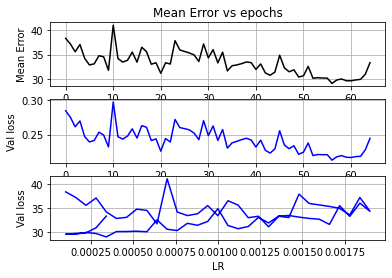

In [48]:
# plt.ioff()
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.ylabel('Mean Error')
plt.xlabel('Per 5 Epochs')
# plt.plot(np.arange(num_epochs), mean_error_over_epochs, 'k-')
plt.plot(mean_error_over_epochs, 'k-')
plt.title('Mean Error vs epochs')
# plt.xticks(np.arange(num_epochs, dtype=int))
plt.grid(True)

plt.subplot(3, 1, 2)
# plt.plot(np.arange(num_epochs), val_loss_over_epochs, 'b-')
plt.plot(val_loss_over_epochs, 'b-')
plt.ylabel('Val loss')
plt.xlabel('Per 5 Epochs')
# plt.xticks(np.arange(num_epochs, dtype=int))
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(lr_over_epochs, mean_error_over_epochs, 'b-')
plt.ylabel('Val loss')
plt.xlabel('LR')
# plt.xticks(np.arange(num_epochs, dtype=int))
plt.grid(True)

plt.savefig("mp4_q2_plot.png")
# plt.close(fig)

# plt.ion()

In [49]:
# !ls
# torch.save(model, './model_'+str(epoch))
# !ls

# model = torch.load('./model_56')
# model

MyModel(
  (resnet18_head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (resnet18_layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

# You do not need to change anything below


Validation loss (L1): 0.21295185992096224
Validation metrics: Mean 29.0, Median 19.5, 11.25deg 35.2, 22.5deg 54.1, 30deg 62.4


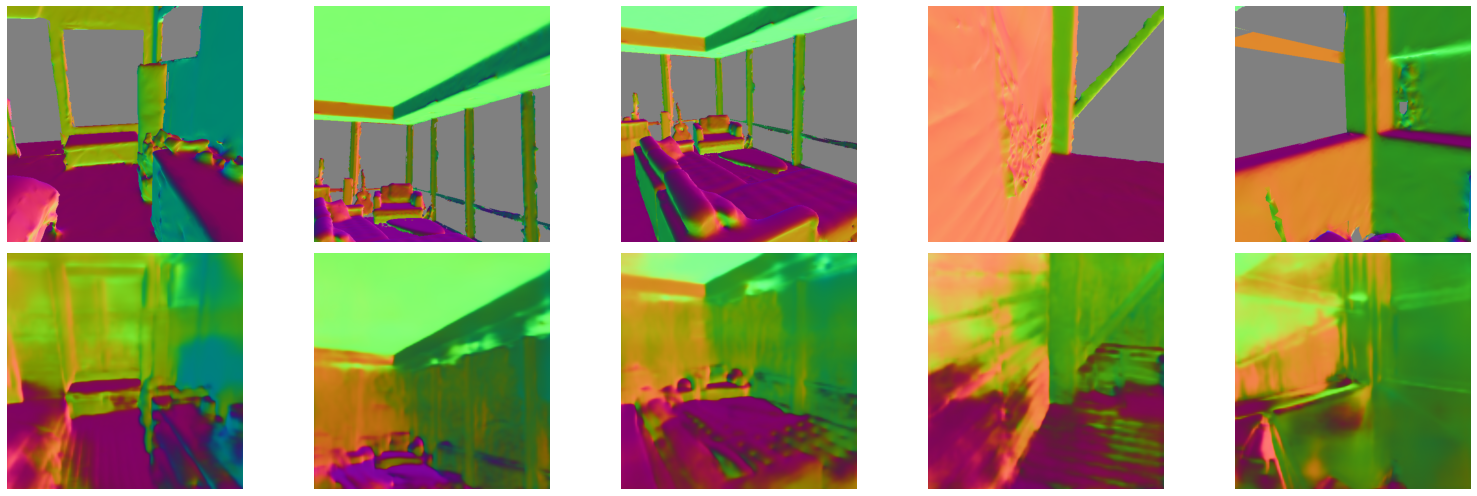

In [50]:
########################################################################
# Evaluate your result, and report
# 1. Mean angular error
# 2. Median angular error
# 3. Accuracy at 11.25 degree
# 4. Accuracy at 22.5 degree
# 5. Accuracy at 30 degree
# using provided `simple_predict` function.

val_gts, val_preds, val_losses, val_total_normal_errors = simple_predict('val', model)
print("Validation loss (L1):", np.mean(val_losses))
print("Validation metrics: Mean %.1f, Median %.1f, 11.25deg %.1f, 22.5deg %.1f, 30deg %.1f" % (
    np.average(val_total_normal_errors), np.median(val_total_normal_errors),
    np.sum(val_total_normal_errors < 11.25) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 22.5) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 30) / val_total_normal_errors.shape[0] * 100
))

# vis validation
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(val_gts[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(val_preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('vis_valset.pdf', format='pdf', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


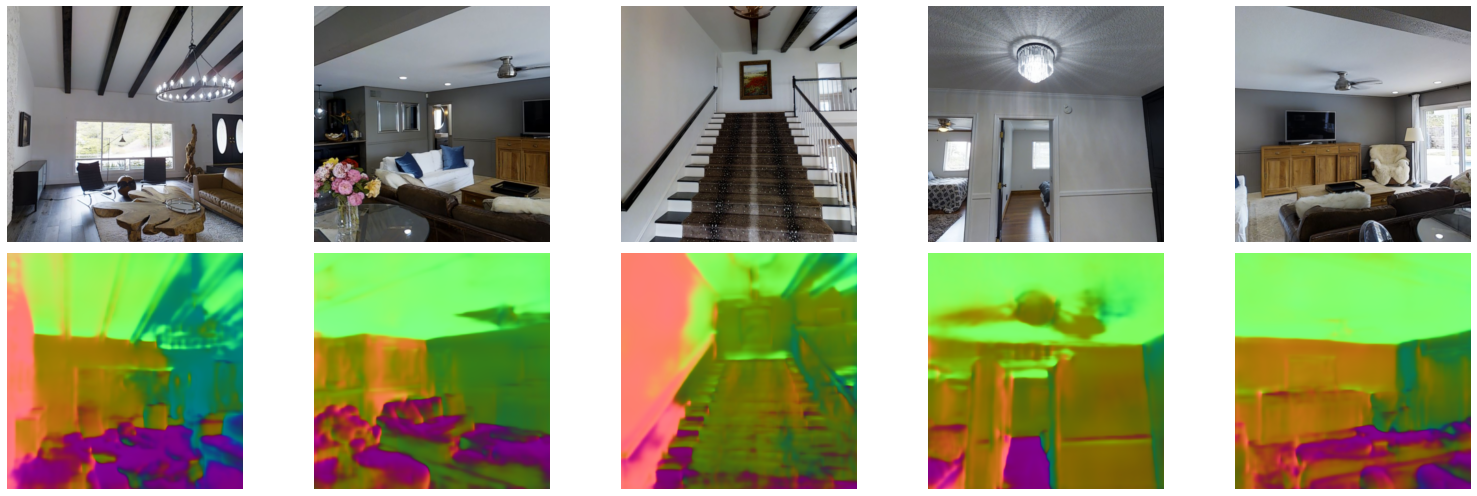

In [51]:
# Visualization
# pick some of your favorite images and put them under `./data/normal_visualization/image`

class VisualizationDataset(data.Dataset):
    def __init__(self, image_dir="./data/normal_visualization/image", image_ext=".png"):
        self.img_dir = image_dir
        self.img_ext = image_ext
        
        self.image_filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*" + image_ext)
        ]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        filename = self.image_filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + self.img_ext)
        img = np.asarray(img).copy()
        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        
        return img.contiguous(), filename

def simple_vis(model):
    model.eval()
    dataset = VisualizationDataset(image_dir="./data/normal_visualization/images")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    imgs, preds = [], []

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, _ = batch
            img = img.to(device)

            pred = model(img)
            imgs.append(
                std * img[0].permute((1, 2, 0)).cpu().numpy() + mean
            )
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)

    return imgs, preds

imgs, preds = simple_vis(model)
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(imgs[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('q2_visualization.pdf', format='pdf', bbox_inches='tight')

In [52]:
# Test your model on the test set, submit the output to gradescope

from PIL import Image

def simple_test(model, out_dir):
    model.eval()
    dataset = VisualizationDataset(image_dir="./data/Q2_test_data")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, filename = batch
            img = img.to(device)

            pred = model(img)
            pred = ((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2) * 255
            pred = pred.astype(np.uint8)

            output = os.path.join(out_dir, filename[0] + ".png")

            Image.fromarray(pred).save(output)

out_dir = "Q2_normal_predictions"
os.makedirs(out_dir, exist_ok=True)
simple_test(model, out_dir)